# Metrics

This guide gives you a brief introduction to Rubrix Metrics. Rubrix Metrics enable you to perform fine-grained analyses of your models and training datasets. Rubrix Metrics are inspired by a a number of seminal works such as [Explainaboard](http://explainaboard.nlpedia.ai/). 

The main goal is to make it easier to build more robust models and training data, going beyond single-number metrics (e.g., F1). 

This guide gives a brief overview of currently supported metrics. For the full API documentation see the [Python API reference](../reference/python/python_metrics.rst)


.. nbinfo::
This feature is experimental, you can expect some changes in the Python API. Please report on Github any issue you encounter.

## Install dependencies

For running this guide you need to install the following dependencies:

In [1]:
%pip install datasets spacy plotly -qqq

Note: you may need to restart the kernel to use updated packages.


## Load dataset and spaCy model

We'll be using spaCy for this guide, but all the metrics we'll see are computed for any other framework (Flair, Stanza, Hugging Face, etc.). As an example will use the WNUT17 NER dataset.

In [ ]:
import rubrix as rb
import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm")
dataset = load_dataset("wnut_17", split="train")

## Log records into a Rubrix dataset

In [3]:
from tqdm.auto import tqdm

records = []

for record in tqdm(dataset, total=len(dataset)):
    # We only need the text of each instance
    text = " ".join(record["tokens"])

    # spaCy Doc creation
    doc = nlp(text)

    # Entity annotations
    entities = [
        (ent.label_, ent.start_char, ent.end_char)
        for ent in doc.ents
    ]

    # Pre-tokenized input text
    tokens = [token.text  for token in doc]

    # Rubrix TokenClassificationRecord list
    records.append(
        rb.TokenClassificationRecord(
            text=text,
            tokens=tokens,
            prediction=entities,
            prediction_agent="en_core_web_sm",
        )
    )
rb.delete("spacy_sm_wnut17")
rb.log(records, name="spacy_sm_wnut17")

BulkResponse(dataset='spacy_sm_wnut17', processed=3394, failed=0)

## Explore the metrics for the dataset

In [4]:
from rubrix.metrics.token_classification import entity_consistency

entity_consistency(name="spacy_sm_wnut17", mentions=40, threshold= 3).visualize()

AssertionError: Metric entity_consistency not found !!!

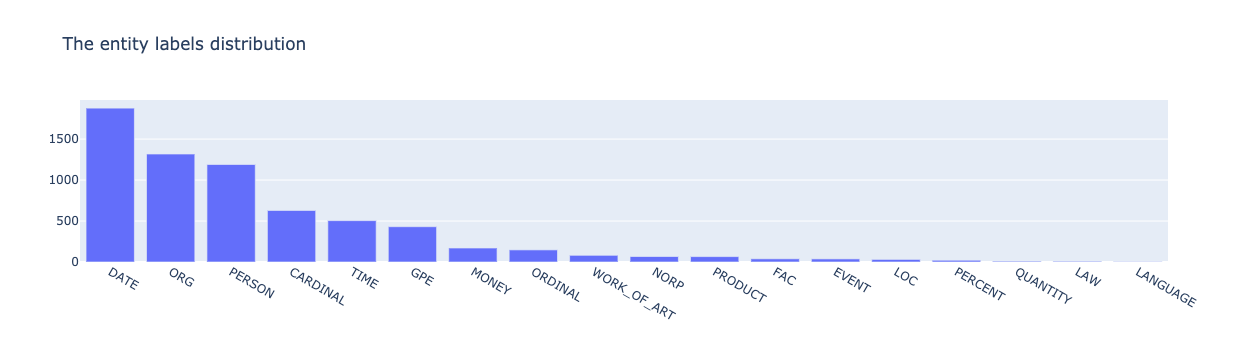

In [15]:
from rubrix.metrics.token_classification import entity_labels

entity_labels(name="spacy_sm_wnut17").visualize()

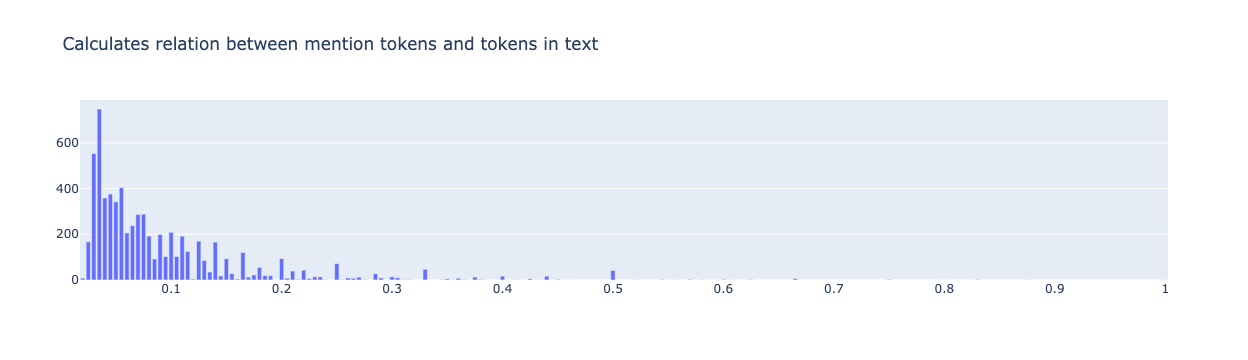

In [16]:
from rubrix.metrics.token_classification import entity_density

entity_density(name="spacy_sm_wnut17").visualize()

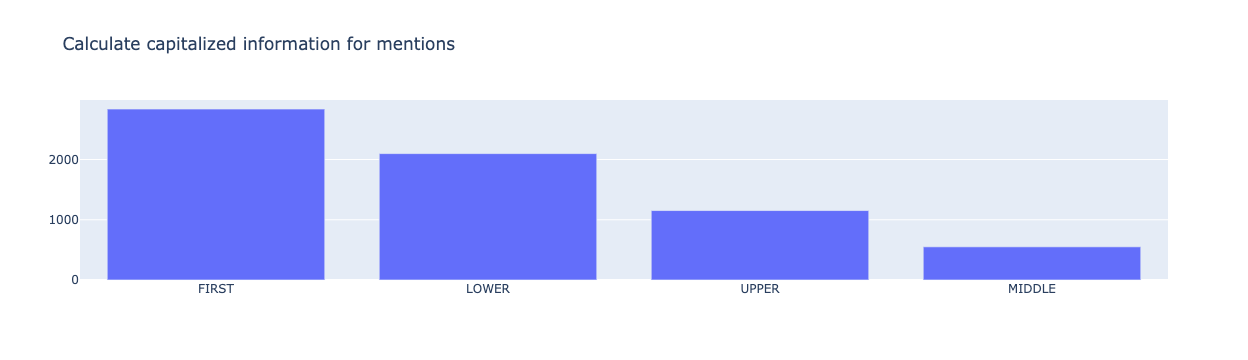

In [17]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="spacy_sm_wnut17").visualize()

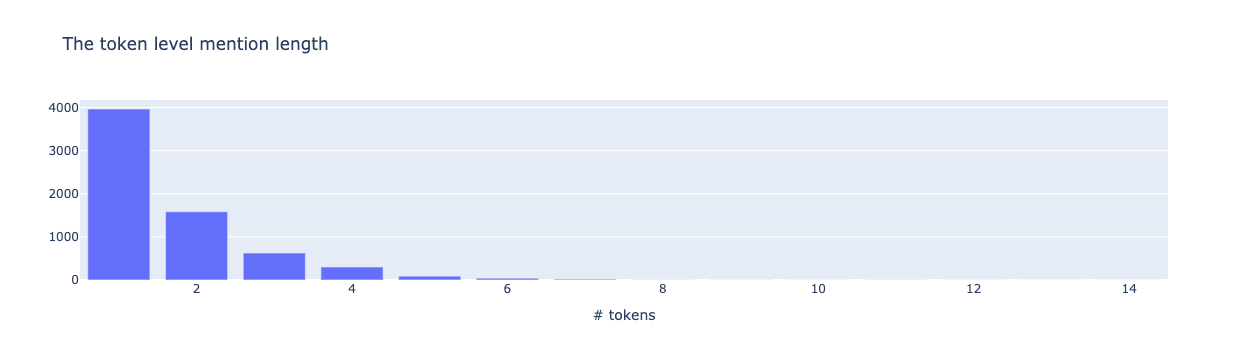

In [18]:
from rubrix.metrics.token_classification import mention_length
mention_length(name="spacy_sm_wnut17").visualize()